In [15]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
# os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
# import rpy2.robjects
# from plotnine import * 
import matplotlib.pyplot as plt 
import copy  

In [16]:
# Importing the model
model1 = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")




In [17]:
# For getting IDs of all fluxes
# biomass_rxn = model1.reactions.get_by_id("BIOMASS_RT")
# ngam_rxn = model1.reactions.get_by_id("ATPM")

solution1 = model1.optimize()
all_fluxes = solution1.fluxes.to_frame(name='Flux')
solution1

,fluxes,reduced_costs
ALCD25yi,0.0,0.000000
MTHFCm,0.0,-0.000000
AMPN,0.0,-0.003773
DAGCPTer_RT,0.0,0.000000
PYRt2,0.0,0.000000
...,...,...
FOLt,0.0,0.000000
NADtm,0.0,0.000000
EX_pydxn_e,0.0,-0.223369
PYDXNtr,0.0,0.000000


In [18]:
glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 3.1] 
growth_rates = [0.033713, 0.081992, 0.122398, 0.172112, 0.232267] # calculated when optimized for biomass max and constraining glucose uptake to lab data: [0.035529, 0.080933, 0.118766, 0.171733, 0.232267]


all_fluxes_NGAM_min = pd.DataFrame(columns=['Growth rate','Glucose uptake', *all_fluxes.index], index=range(len(glucose_uptakes))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(glucose_uptakes)):
# i = 0
    model = cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")
    model.objective =  "ATPM" 
    model.reactions.BIOMASS_RT.bounds = growth_rates[i], growth_rates[i]
    model.reactions.EX_glc__D_e.bounds = -(glucose_uptakes[i]), -(glucose_uptakes[i])

    # biomass_rxn.objective_coefficient = 1
    # ngam_rxn.objective_coefficient = -1
    solution = model.optimize('minimize') #
                            # solution = cobra.flux_analysis.pfba(model) # pFBA - but don't know how to minimize


    all_fluxes_NGAM_min.loc[i] = solution.fluxes[['BIOMASS_RT', 'EX_glc__D_e', *all_fluxes.index]].values

all_fluxes_NGAM_min

,Growth rate,Glucose uptake,ALCD25yi,MTHFCm,AMPN,DAGCPTer_RT,PYRt2,NNDPRm,HMGCOASm,PDE4,...,EX_2hxmp_e,SALCNHe,EX_btn_e,BTNt2i,EX_fol_e,FOLt,NADtm,EX_pydxn_e,PYDXNtr,RIBFLVt2
0,0.033713,-0.476,0.0,0.0,0.0,0.0,0.0,0.0,-0.003255,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.081992,-1.114,0.0,0.0,0.0,0.0,0.0,0.0,-0.007917,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.122398,-1.648,0.0,0.0,0.0,0.0,0.0,0.0,-0.011818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.172112,-2.305,0.0,0.0,0.0,0.0,0.0,0.0,-0.016619,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.232267,-3.1,0.0,0.0,0.0,0.0,0.0,0.0,-0.022427,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
all_fluxes_NGAM_min[['ALCD2y', 'HSDy']]
# model.summary()

,ALCD2y,HSDy
0,0.0,0.546191
1,1.282412,0.0
2,2.006889,-0.082859
3,5.082353,-0.104091
4,6.799168,-0.120749


In [20]:
# Get specific metabolites with their fluxes
exchange_fluxes_table = all_fluxes_NGAM_min[['EX_glc__D_e', 'EX_o2_e', 'EX_nh4_e','EX_so4_e','EX_pi_e', 'EX_co2_e']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,D-Glucose exchange,O2 exchange,Ammonia exchange,Sulfate exchange,Phosphate exchange,CO2 exchange
0,-0.476,-1.149964,-0.222516,-0.003379,-0.008975,1.276335
1,-1.114,-2.535233,-0.541177,-0.008219,-0.021828,2.842452
2,-1.648,-3.69447,-0.807868,-0.012269,-0.032584,4.15009
3,-2.305,-5.120758,-1.135994,-0.017252,-0.045819,5.765779
4,-3.1,-6.846203,-1.53303,-0.023282,-0.061833,7.711018


In [21]:
intracellular_fluxes = all_fluxes_NGAM_min[[ 'ATPM', 'EX_glc__D_e', 'G6PDH2r', 'TKT1', 'TALA','TKT2', 'XPK', 'FBA', 'PYRDC','PDHm', 'ACITL']]

for i in range(len(intracellular_fluxes.columns)):
    if intracellular_fluxes.columns[i] != 'TKT1' and intracellular_fluxes.columns[i] != 'TKT2':
        intracellular_fluxes = intracellular_fluxes.rename(columns = {intracellular_fluxes.columns[i]: getattr(model.reactions, intracellular_fluxes.columns[i]).name})

# Adding XPK and FPK together
intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] = intracellular_fluxes['Xylulose-5-phosphate phosphoketolase'] + all_fluxes_NGAM_min['FPK']

# Change G6PDH2rp column name to oxpp 
intracellular_fluxes = intracellular_fluxes.rename(columns = {'G6PDH2r': 'oxPPP', 'ATP maintenance requirement': 'NGAM', 'Xylulose-5-phosphate phosphoketolase': 'Phosphoketolase', 
                                                              'TKT1': 'Transketolase 1', 'TKT2': 'Transketolase 2'})
intracellular_fluxes

,NGAM,D-Glucose exchange,Glucose 6-phosphate dehydrogenase,Transketolase 1,Transaldolase,Transketolase 2,Phosphoketolase,Fructose-bisphosphate aldolase,Pyruvate decarboxylase,Pyruvate dehydrogenase,ATP-Citrate lyase
0,1.22,-0.476,0.0,-0.076357,-0.307591,0.0,0.181049,0.0,0.015571,0.427715,0.0
1,1.22,-1.114,0.0,-0.185643,-0.704482,0.239139,0.440129,0.0,0.057207,0.940951,0.0
2,1.22,-1.648,0.0,-0.277161,-1.036638,0.0,0.657126,0.0,0.100496,1.374625,0.0
3,1.22,-2.305,0.0,-0.389753,-0.389753,0.0,0.924085,1.055552,0.153738,1.908194,0.0
4,1.22,-3.1,0.0,-0.526051,-0.526051,0.677771,1.247295,1.413706,0.236023,2.562563,0.0


Text(0, 0.5, 'Flux $(g/gDW/h)$')

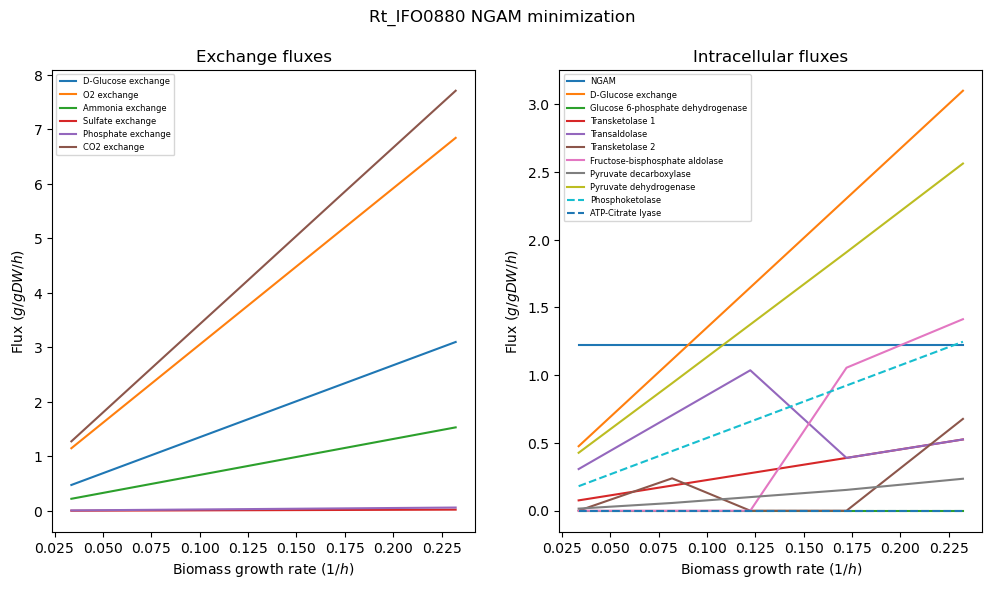

In [22]:
# Plot exchange and intracellular fluxes
fig, ax = plt.subplots(1, 2, figsize=(12,6)) #, 
fig.suptitle('Rt_IFO0880 NGAM minimization')

# Sample data

x1 = all_fluxes_NGAM_min['BIOMASS_RT']
y1 = np.abs(exchange_fluxes_table)

ax[0].plot(x1, y1, '-', label= y1.columns) #
ax[0].legend(fontsize=6, loc='upper left')
ax[0].set_title("Exchange fluxes") #fluxes biomass maximization
ax[0].set_xlabel('Biomass growth rate $(1/h)$')
ax[0].set_ylabel('Flux $(g/gDW/h)$')

x2 = all_fluxes_NGAM_min['BIOMASS_RT']
y2 = np.abs(intracellular_fluxes.drop(columns = ['Phosphoketolase','ATP-Citrate lyase']))
y3 = np.abs(intracellular_fluxes[['Phosphoketolase','ATP-Citrate lyase']])

ax[1].plot(x2, y2, '-', label= y2.columns) #
ax[1].plot(x2, y3, '--', label= y3.columns) # ACL and phosphoketolase

ax[1].legend(fontsize=6, loc='upper left')
ax[1].set_title("Intracellular fluxes")
ax[1].set_xlabel('Biomass growth rate $(1/h)$')
ax[1].set_ylabel('Flux $(g/gDW/h)$')

See Rt_IFO0880_cofactor_balances file

In [23]:
# # Get all fluxes to excel
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\Glucose_maximization\\all_fluxes_dif_GR.xlsx') as excel_writer:
#     all_fluxes_dif_GR.to_excel(excel_writer, sheet_name='Glucose uptake range 0.49-3.1', index=True)
    
# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\Glucose_maximization\\exchange_fluxes_dif_GR.xlsx') as excel_writer:
#     exchange_fluxes_table_all.to_excel(excel_writer, sheet_name='Exchange fluxes', index=True)

In [24]:
# # # #  Get csv files
# glucose_uptakes= [0.476, 1.114, 1.648, 2.305, 2.6619851, 3.1]
# i = 2
# all_fluxes_NGAM_min.loc[i].to_csv(f'C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Rt_IFO0880_results\\fluxes_NGAM_min_glucose_uptake_{glucose_uptakes[i]}.csv', index=True)
